In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#random_seed = np.random.randint(0, 2**32 - 1)
random_seed = 1254175674
print('random seed:', random_seed)

random seed: 1254175674


<ErrorbarContainer object of 3 artists>

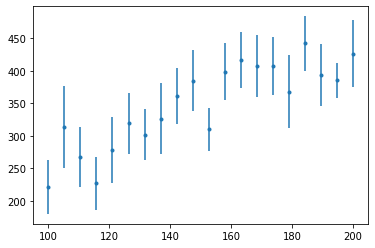

In [2]:
np.random.seed(random_seed)
def line(x,ms,ds):
    return x*ms+ds

breakpoint = 180
ndata = 20
x_obs = np.linspace(100,200,ndata)
y_truth = (line(x_obs,2,5) * np.array([x_obs<breakpoint])[0]) + (line(x_obs,1,breakpoint) * np.array([x_obs>=breakpoint])[0])
#y_truth = line(x_obs,2,5)
y_obs = y_truth + np.random.normal(50,30,ndata)
y_er = abs(np.random.normal(40,10,ndata))
plt.errorbar(x_obs,y_obs,y_er,fmt='.')

In [3]:
with pm.Model() as model:
    m = pm.Normal('slope',4,0.2)
    d = pm.Normal('intcp',-10,10)
    Y = pm.Normal('Y',line(x_obs,m,d),y_er,observed=y_obs)
    trace = pm.sample(50000,tune=1000,random_seed=random_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intcp, slope]
Sampling 4 chains, 0 divergences: 100%|██████████| 204000/204000 [00:24<00:00, 8190.58draws/s]


/home/arash/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


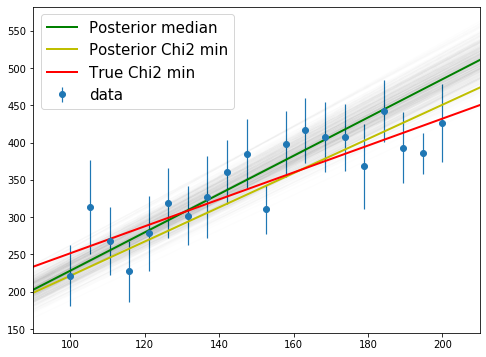

In [4]:
par,cov = curve_fit(line,x_obs,y_obs,sigma=y_er,method='lm')

posterior_chi2 = np.ndarray(len(trace))
for i in range(len(trace)):
    y_model = x_obs*trace['slope'][i]+trace[i]['intcp']
    posterior_chi2[i] = sum((y_obs - y_model)**2 / y_er**2)    

plt.figure(figsize=(8,6))
plt.errorbar(x_obs,y_obs,y_er,fmt='o',ms=6,elinewidth=1.2,label='data')
xtest = np.linspace(90,210,500)
for i in np.random.randint(0,len(trace),400):
    plt.plot(xtest,xtest*trace['slope'][i]+trace[i]['intcp'],'-k',alpha=0.008)
    
plt.plot(xtest,xtest*np.median(trace['slope'])+np.median(trace['intcp']),'-g',lw=2,label='Posterior median')
plt.plot(xtest,xtest*trace['slope'][posterior_chi2.argmin()]+trace[posterior_chi2.argmin()]['intcp'],'-y',lw=2,label='Posterior Chi2 min')
plt.plot(xtest,xtest*par[0]+par[1],'-r',lw=2,label='True Chi2 min')
plt.xlim(90,210)
plt.legend(fontsize=15)